# Latex with Jinja2

[Jinja2](http://jinja.pocoo.org/docs/2.9/) is a templating engine for python. It is mostly known in combination with the micro web service [Flask](http://flask.pocoo.org/). However, it can not only be used to modify HTML files, but all sort of text files. Here I want to show you how to use Jinja2 in combination with [Latex](https://www.latex-project.org/). Latex allows you to create high quality documents. It is the de facto standard for the publication of scientific documents.  
With this combination we are able to create automatically highly professional reports. There is another Python library called [PyLaTeX](https://github.com/JelteF/PyLaTeX) with which you can perform the same task. If you start completely from the beginning it might be a good choice. PyLaTeX is completely in Python and there are no .tex files needed. However, Jinja2 makes it possible to adopt existing Latex reports and it separates the logic from the presentation.  
That is enough with the introductory word, lets start.

Jinja2 conflicts with the Latex commands. [This](http://eosrei.net/articles/2015/11/latex-templates-python-and-jinja2-generate-pdfs) blog post shows a solution to solve this problem. The Jinja environment can be changed to mimic the Latex environment.  
All our .tex template files lie in the Templates folder. We get the path to the directory by importing templates.

In [1]:
import os
import jinja2
import templates

latex_jinja_env = jinja2.Environment(
    block_start_string='\BLOCK{',
    block_end_string='}',
    variable_start_string='\VAR{',
    variable_end_string='}',
    comment_start_string='\#{',
    comment_end_string='}',
    line_statement_prefix='%%',
    line_comment_prefix='%#',
    trim_blocks=True,
    autoescape=False,
    loader=jinja2.FileSystemLoader(os.path.join(os.path.dirname(templates.__file__), 'latex')))

The function print_template is a small helper function to show you the content of the template files.

In [2]:
def print_template(template):
    print(latex_jinja_env.loader.get_source(latex_jinja_env, template)[0])

The next function compiles rendered Latex strings to an output PDF file. A temporary directory is created to put the rendered .tex files into. Pdflatex is a console program that compiles Latex files to PDF files. It is executed with Popen from the subprocess module. On my Windows machine I have installed [Miktex](https://miktex.org/), which comes with pdflatex.

In [3]:
from subprocess import Popen
import os
import tempfile
import shutil

def compile_tex(rendered_tex, out_pdf_path):
    tmp_dir = tempfile.mkdtemp()
    in_tmp_path = os.path.join(tmp_dir, 'rendered.tex')
    with open(in_tmp_path, 'w') as outfile:
        outfile.write(rendered_tex)
    out_tmp_path = os.path.join(tmp_dir, 'out.pdf')
    p = Popen(['pdflatex', in_tmp_path, '-job-name', 'out', '-output-directory', tmp_dir])
    p.communicate()
    shutil.copy(out_tmp_path, out_pdf_path)
    shutil.rmtree(tmp_dir)

To show you the output PDF file I render it as an image with the [wand](http://docs.wand-py.org/en/0.4.4/) package.

In [4]:
from wand.image import Image as WImage

def compile_tex_to_image(rendered_tex):
    tmp_dir = tempfile.mkdtemp()
    out_path = os.path.join(tmp_dir, 'out.pdf')
    compile_tex(rendered_tex, out_path)
    img = WImage(filename=out_path)
    shutil.rmtree(tmp_dir)
    return img

Let's look into the first example template 'hello_world.tex'. It simply renders the variable text.

In [5]:
print_template('hello_world.tex')

\documentclass{article}

\begin{document}
  \Huge
  \VAR{text}
\end{document}


By passing 'Hello World' to the template we create our first Jinja/Latex result with the following output.

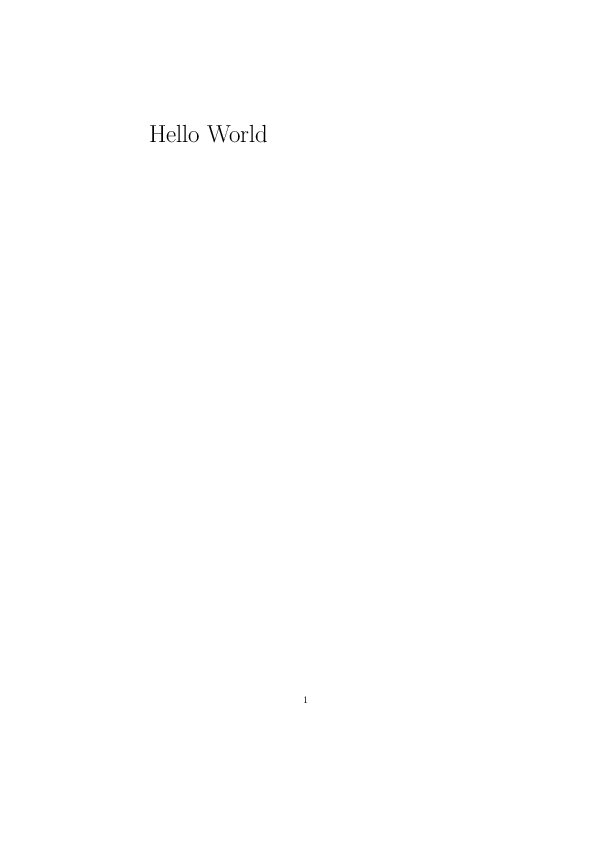

In [6]:
template = latex_jinja_env.get_template('hello_world.tex')
rendered_tex = template.render(text='Hello World')
compile_tex_to_image(rendered_tex)

The next template plots a given image with a caption.

In [7]:
print_template('figure.tex')

\documentclass{article}
\usepackage{graphicx}

\begin{document}
  \begin{figure}
    \includegraphics[width=\linewidth]{\VAR{image_path}}
    \caption{\VAR{caption}}
  \end{figure}
\end{document}


The result is demonstrated with the astronaut image from skimage.

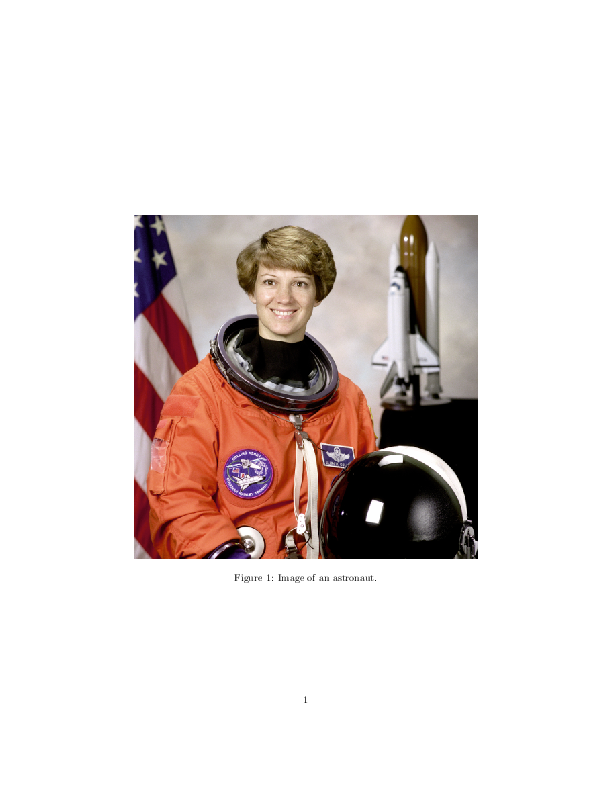

In [8]:
import skimage

image_path = os.path.join(skimage.data_dir, 'astronaut.png')
caption = 'Image of an astronaut.'

template = latex_jinja_env.get_template('figure.tex')
rendered_tex = template.render(image_path=image_path.replace('\\', '/'), caption=caption)
compile_tex_to_image(rendered_tex)

The last Latex template shows you how to fill tables with Jinja. We iterate over the rows of a Pandas Dataframe to fill the entries of the table. The Dataframe consist of weather information of multiple days.

In [9]:
print_template('table.tex')

\documentclass{article}
\usepackage{graphicx}

\begin{document}
  \begin{tabular}{ | l | l | l | p{5cm} |}
    \hline
    Day & Min Temp & Max Temp & Summary \\ \hline
    \BLOCK{ for _, row in df.iterrows() }
      \VAR{row.day} & \VAR{row.min_temp} & \VAR{row.max_temp} & \VAR{row.summary} \\ \hline 
	\BLOCK{ endfor }
  \end{tabular}
\end{document}


Here you see the result of the rendered table in Latex for a given Pandas Dataframe.

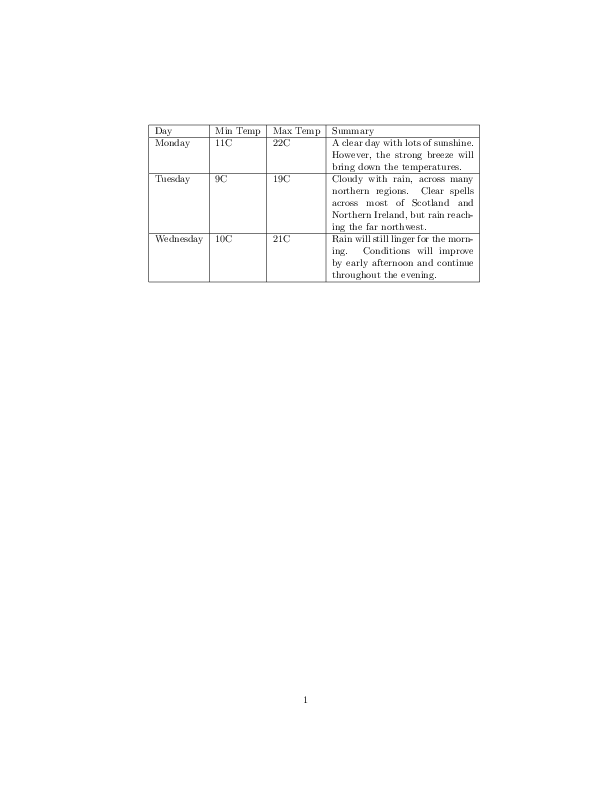

In [10]:
import pandas as pd

df = pd.read_csv(r'C:\Users\Artur\Development\workspace\MachineLearning\templates\latex\table.csv', sep=';')
template = latex_jinja_env.get_template('table.tex')
rendered_tex = template.render(df=df)
compile_tex_to_image(rendered_tex)

We started with a short introduction to why Jinja2 and Latex is a great combination. The Jinja2 environment has to be changed to be Latex compatible. We have created a simple hello world example, plotted an image as figure and filled a table with a Pandas Dataframe.